# ATS 601: Atmospheric Dynamics I

### Tyler Barbero | Due 9/3

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import warnings

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
large = 28; med = 24; small = 15
params = {'axes.titlesize': small,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': small,
          'axes.titlesize': small,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': med,
          'axes.titlepad': 10,
         'axes.facecolor': 'black'} # For electric background plots
plt.rcParams.update(params)

### Problem 1: Passive tracer advection

1e) Step 2: Convert your equation from (d) into numerical form, and solve for the density $ψ
^{i+1}_{j}$ at a future time $i + 1$ at location $j$.


<i>i,j notational form of continuity equation</i><br>
$\psi_j^{i+1} = \psi_j^{i} - \Delta t \Lambda  \psi_j^{i} - \frac{\Delta t \Lambda |x|}{\Delta x} (\psi_j^{i} - \psi_{j-1}^{i})$ for x > 0 and 

$\psi_j^{i+1} = \psi_j^{i} + \Delta t \Lambda  \psi_j^{i} - \frac{\Delta t \Lambda |x|}{\Delta x} (\psi_j^{i} - \psi_{j-1}^{i})$ for x < 0.

<i>Numerical form of continuity equation</i><br>
$psi[xi,ti+1] = psi[xi,ti]+(dt*A*psi[xi,ti])-(A*np.abs(x[xi])*(dt/dx)*(psi[xi,ti]-psi[xi-1,ti]))$ for x > 0 and
$psi[xi,ti+1] = psi[xi,ti]-(dt*A*psi[xi,ti])-(A*np.abs(x[xi])*(dt/dx)*(psi[xi,ti]-psi[xi-1,ti]))$ for x < 0.


In [4]:
dt = 0.01
dx = 0.10
mu = 5 
A = 0.1 #lambda
sigma = 1


# Define time and space and psi arrays
t = np.arange(0,22,dt)
x = np.arange(-100,100,dx)


In [5]:
# assign array for psi
psi = np.zeros([len(x),len(t)])

# intial condition
psi_0 = np.exp(-1*((x-mu)**2)/(2*sigma**2))
psi[:,0] = psi_0

# code up numerical equation
# tmp = psi[xi,ti]+(dt*A*psi[xi,ti])-(A*np.abs(x[xi])*dt/dx*(psi[xi,ti]-psi[xi-1,ti]))

# emnumerate gets the index and value
for ti,tv in enumerate(t[1:]):
    for xi,xv in enumerate(x[1:]):
        
        # calculating psi at each x and at each t index
    
        # case where value of x < 0
        if xv < 0:
            psi[xi,ti+1] = psi[xi,ti]+(dt*A*psi[xi,ti])-(A*np.abs(x[xi])*(dt/dx)*(psi[xi,ti]-psi[xi-1,ti]))
        
        # case where value of x > 0 
        elif xv > 0: 
            psi[xi,ti+1] = psi[xi,ti]-(dt*A*psi[xi,ti])-(A*np.abs(x[xi])*(dt/dx)*(psi[xi,ti]-psi[xi-1,ti]))

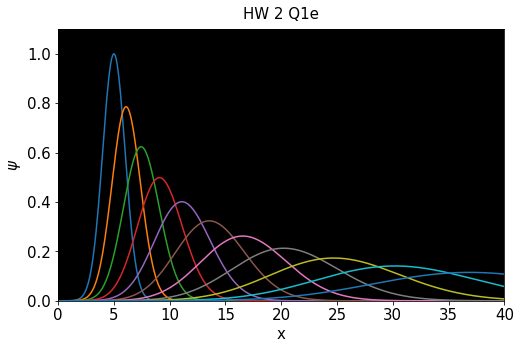

In [6]:
plt.figure(figsize=(8,5))
for i in np.arange(0,len(t),200):
    plt.plot(x,psi[:,i]);
#     plt.legend([i])

plt.xlabel('x');
plt.ylabel('$\psi$');
plt.xlim([0,40])
plt.ylim([0,1.1])
plt.title('HW 2 Q1e');

### Problem 2: Reading-in global atmospheric data

In [7]:
ds = xr.open_dataset('/Users/tyler/Desktop/601/homework_2_ERA-interim_300hPa_2014-Jan1-8.nc')

In [8]:
u = ds.u
v = ds.v

In [9]:
latitude = ds.latitude
longitude = ds.longitude
time = ds.time

### Problem 3: Approximations to the momentum equations (gravity, viscosity)

(a) Using the data from Problem 2, estimate typical values* of the local accelerations of the zonal and
meridional wind in the Northern midlatitudes (30-60 N), namely: ∂u/∂t and ∂v/∂t

In [10]:
u_midlat = u.sel(latitude=slice(60,30))
v_midlat = v.sel(latitude=slice(60,30))

In [11]:
dudt = np.zeros(np.shape(u_midlat))
dvdt = np.zeros(np.shape(v_midlat))

for i in np.arange(1,np.shape(dudt)[0]-1):
    dudt[i-1,:,:] = (u_midlat[i+1,:,:] - u_midlat[i-1,:,:])/(2*6*60*60)
    dvdt[i-1,:,:] = (v_midlat[i+1,:,:] - v_midlat[i-1,:,:])/(2*6*60*60)

In [12]:
# calculate typical values using RMS
def RMS(matrix):
    tmp = matrix**2
    tmp = np.mean(tmp)
    tmp = np.sqrt(tmp)
    return tmp

In [13]:
print('The RMS or typical values of the zonal wind is: '+str(RMS(dudt))+' m/s')
print('The RMS or typical values of the meridional wind is: '+str(RMS(dvdt))+' m/s')

The RMS or typical values of the zonal wind is: 0.00024879785447811195 m/s
The RMS or typical values of the meridional wind is: 0.0003477727871243218 m/s


(b) Estimate the magnitude of the wind tendencies due to viscosity in the momentum equations for the
atmosphere. You can do this a variety of ways, some easier than others. I would suggest following
the scaling method in Vallis (link to textbook on Canvas) that uses the Reynolds number (section
1.11.1, page 44), as this will provide a ballpark solution in record time. Alternatively, you can try and
calculate the laplacian of the wind on the sphere and compute the actual term (much more difficult).

- I found a typical value of viscosity for air to be $\nu = 1.81e-5$ at 15 degrees C. From this page (https://www.ncdc.noaa.gov/sotc/global/202004), NOAA says the average global temperature from the 20th century was 13.7C (I couldnt find global average for the 2000-2021.) It will probably be higher in 2000-2021 so I think this is close enough.<br>
- I chose a typical characteristic length scale as $L = 10^7 m$ because from lecture I think from lecture it said synoptic scales were between $10^6$ and $10^8m$. And definitely we're looking at midlatitudes between 30 and 60N which is definitely a synoptic scale.
- For a characteristic velocity scale I took the average of the RMS of the zonal and meridional component of wind speeds. For a typical velocity, I found $ U = 35.7 m/s$.
- Finally, using the Force due to viscosity scaling in Vallis: ($\nu\frac{U}{L^2}$)

In [14]:
# Typical value of viscoity (https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm)
v = 1.81e-5 # units: kg/(m*s)

# Typical characteristic length scale (L) (between 10^6 and 10^8)
L = 10**7 # units: meters

# Typical characteristic velocity scale (average both du_dt and dv/dt)
U = np.sqrt(RMS(u_midlat)**2 + RMS(v_midlat)**2)

# Contribution due to viscosity is v*U/L^2
F_v = v*U/(L**2)
print('Typical force due to viscosity is: '+str(np.array((F_v))))

Typical force due to viscosity is: 6.460452476501464e-18


- The typical time tendencies due to force of viscosity is **$6.5e-18 kg/m^2s^2$**. (F/m = acceleration)
- Compared to time tendecies of wind (du/dt and dv/dt), from a) those values were magnitude **$10^{-4} m/s^2$**. 
- Therefore, I since the difference in magnitudes is so large, I think it is okay to neglect viscosity in this course.